# JSC270 Assignment 2: Yelp Business Types and Relationships {-}

## Shirley Wang {-}
## Feb 24, 2019 {-}

---

# Introduction

> Yelp is a local-search service powered by crowd-sourced review forum run by an American multinational corporation. It develops, hosts and markets Yelp.com and the Yelp mobile app, which publish crowd-sourced reviews about local businesses, as well as the online reservation service Yelp Reservations. The Yelp.com automated filter algorithm removes many positive reviews from companies, in view to avoid fake reviews, which has caused controversy. (see Yelp's fake review problem)
Yelp was founded in 2004. By 2010 it had $30 million in revenues and the website had published more than 4.5 million crowd-sourced reviews. From 2009 to 2012, Yelp expanded throughout Europe and Asia. During the fourth quarter of 2017, Yelp has 77 million unique visitors via desktop computer and 64 million unique visitors via mobile website on a monthly average basis. By the end of 2017, Yelp had 148 million reviews.

-- Adapted from Wikipedia

In this report I will analyze the Yelp dataset and use it to investigate the cities and most popular business types on Yelp. I will investigate what kind of businesses tend to have bike parking, and if reviews are correlated with ratings.  I will also investigate Canadian businesses and businesses in the Greater Toronto Area specifically, and analyze Tim Hortons and Starbucks distances and reviews.  I will specifically be answering these questions:

## Questions
1. Loading the Yelp Dataset Challenge (Round 13)

    1.1. Permissions. Before downloading, read the Dataset License and explain in a few sentences what you can and cannot do with this data using your own words.

    1.2. The data. Before loading the data, get yourself acquainted with the data. How is the dataset structured and what relationships are present between the different files?


2. All businesses

    2.1. What cities does this dataset encompass?

    2.2. What are the most frequent business categories overall?

    2.3. What types of establishments tend to have bike parking?

    2.4. An article recently claimed that having more yelp reviews lead to a higher rating, and hence increased sales. Do the data support this claim?


3. Canadian businesses

    3.1. What cities does this dataset encompass?

    3.2. Identify the larger metropolitan regions that these cities belong to.
    

4. GTA businesses

    4.1. What are the most frequent business categories? How do they compare against the trends listed in 2.2?

    4.2. What are the top franchises in the city?

    4.3. Does business location play an important role in reviews?

    4.4. Is it true that for every Tim Hortons in the GTA there is a Starbucks nearby? Calculate distances between establishments of the two groups and assess distance patterns. Plot the two types of establishments on a map.

    4.5. Do Yelp reviewers use similar language in their reviews of GTA's Tim Horton's and Starbucks?

In [1]:
# Code for Question 1: Loading Data
import pandas as pd
import json
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# display dataframes nicely in the pdf
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_

In [2]:
# load business data
# time: 12 seconds
businessdat = pd.read_json('data/business.json', lines = True)

In [3]:
# loads checkin data
# time: 12 seconds
checkindat = pd.read_json('data/checkin.json', lines=True)

In [4]:
# loads photo data
# time: 5 seconds
photodat = pd.read_json('data/photo.json', lines=True)

In [5]:
# loads tip data
# time: 15 seconds
tipdat = pd.read_json('data/tip.json', lines=True)

In [6]:
# just get columns of user and review for table
with open("data/review.json", encoding="utf8") as f:
    for line in f:
        data = json.loads(line)
        break
reviewcol = list(data.keys())

In [7]:
with open("data/user.json", encoding="utf8") as f:
    for line in f:
        data = json.loads(line)
        break
usercol = list(data.keys())

# Question 1: Loading the Yelp Dataset Challenge (Round 13)

## 1.1. Permissions

This Yelp dataset is distributed with the purpose of us participating in Yelp's Dataset Challenge.  We are allowed to analyze this data for academic purposes only, to learn things from it. But Yelp still owns the data and as a result has the right to know what we do with the data.  We aren't allowed to profit from it, publicly display it, use it to compete with Yelp, or do anything illegal with the data.

## 1.2. Data

In [15]:
def fillin(columns):
    length = len(columns)
    for i in range(22 - length):
        columns.append('')    

businesscol = list(businessdat.columns)
fillin(businesscol)
checkincol = list(checkindat.columns)
fillin(checkincol)
tipcol = list(tipdat.columns)
fillin(tipcol)
photocol = list(photodat.columns)
fillin(photocol)
fillin(reviewcol)

columns = pd.DataFrame()

def highlight_overlap(s):
    return ['background-color: yellow' if v == 'business_id'
            else 'background-color: pink' if v == 'user_id'
            else '' 
            for v in s]

columns["business"] = businesscol
columns["checkin"] = checkincol
columns["tip"] = tipcol
columns["photo"] = photocol
columns["review"] = reviewcol
columns["user"] = usercol

# does not work for pdf conversion
display(columns.style.apply(highlight_overlap))

# display(columns)

,business,checkin,tip,photo,review,user
0,address,business_id,business_id,business_id,review_id,user_id
1,attributes,date,compliment_count,caption,user_id,name
2,business_id,,date,label,business_id,review_count
3,categories,,text,photo_id,stars,yelping_since
4,city,,user_id,,useful,useful
5,hours,,,,funny,funny
6,is_open,,,,cool,cool
7,latitude,,,,text,elite
8,longitude,,,,date,friends
9,name,,,,,fans


The dataset is stored in the JSON file format, with each line representing an entry in its dataframe.

The business dataset contains information about every business in Yelp, corresponding to its own unique business id.
The checkin dataset contains information about the number of times each business has checked in with Yelp.
The review dataset contains information about reviews on Yelp, with each one having the business id of the business, the user id of the user who provided the review, and its corresponding unique review id.
The photo dataset contains information about every photo on Yelp and the business id of the business that the photo belongs to.
The tip dataset contains information about tips on Yelp, with each one having the business id of the business, and the user id of the user who provided the tip.
The user dataset contains information about every user on Yelp, the number of reviews and statistics of reviews they've made, and their corresponding user id.

The main thing to note is that many of these datasets share business ids and user ids, which each correspond to a specific user or business that uses Yelp and identify what belongs to who.

# Question 2: All businesses

## 2.1. What cities does this dataset encompass?

We will graph all of the cities in this dataset on a map of the world and North America, and see which cities have the most businesses within them in this dataset.

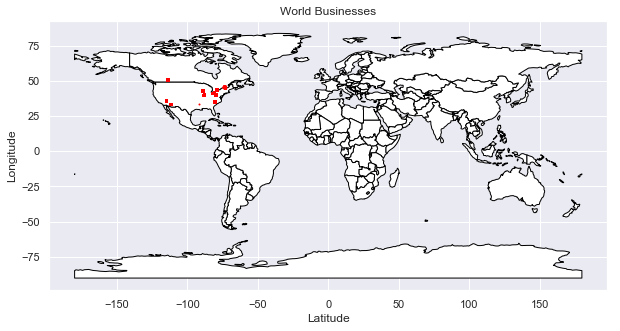

In [11]:
import geopandas as gp
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import seaborn as sns
sns.set()

# load map data
geometry = [Point(xy) for xy in zip(businessdat.longitude, businessdat.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(businessdat, crs=crs, geometry=geometry)
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

base = world.plot(color='white', edgecolor='black', figsize=(10, 6))
gdf.plot(ax=base, color='red', markersize=1)
base.set_title("World Businesses")
base.set_xlabel("Latitude")
base.set_ylabel("Longitude")
plt.show()

We can see that all of the businesses in the dataset are located in North America.

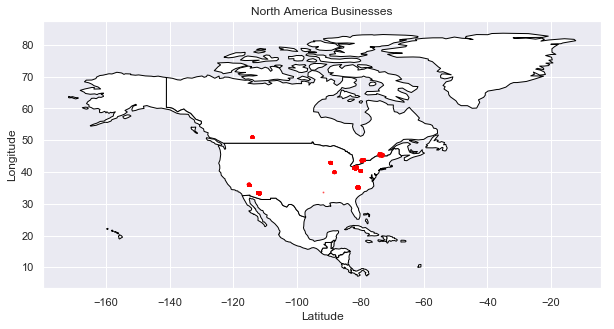

In [11]:
# Restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(10, 7))

gdf.plot(ax=ax, color='red', markersize=1, alpha=0.5)
ax.set_title("North America Businesses")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
plt.show()

We can see that all of the businesses in this dataset are concentrated in certain regions of North America.  It is not a good representation of businesses across North America, or even USA or Canada.  From this, we can infer that the given dataset is most likely not a random sample of businesses on Yelp, but rather the businesses from a few selected big cities across North America.

The 10 cities with the most businesses present within the dataset are:

In [21]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

# website with metropolitan regions written in it
# it doesn't have all of the cities in it
# for better analysis, we need a complete list of populations for all North American cities
webpage = 'https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population'
scraped = pd.read_html(webpage)

populations = scraped[0]

populations = populations.drop(columns=[0, 2, 5])
populations = populations.rename(columns={1: 'City', 3: 'Country', 4: 'Population'})
populations = populations[1:]
populations = populations.reset_index(drop=True)
for i in range(len(populations)):
    populations.loc[i, 'Population'] = populations.loc[i, 'Population'].split('[')[0]

populations['Population'] = populations['Population'].replace(',', '', regex = True).astype(int)

def getPopulation(city):
    pop = populations[populations['City'] == city]['Population']
    if len(pop) > 0:
        return pop.values[0]
    else:
        return 0

In [13]:
top10cities = businessdat['city'].value_counts()[0:10]
top10 = pd.DataFrame(top10cities).reset_index()
top10['index'] = top10['index'].replace('MontrÃ©al', "Montreal")
top10.columns = ['City', 'Business Count']

top10['Population'] = [getPopulation(city) for city in top10['City']]
top10.loc[4, 'Population'] = 249950
top10.loc[6, 'Population'] = 302407
top10.loc[8, 'Population'] = 496401
top10.loc[9, 'Population'] = 302539
display(top10)

,City,Business Count,Population
0,Las Vegas,29370,623747
1,Toronto,18906,2826498
2,Phoenix,18766,1563025
3,Charlotte,9509,827097
4,Scottsdale,8837,249950
5,Calgary,7736,1230915
6,Pittsburgh,7017,302407
7,Montreal,6449,1753034
8,Mesa,6080,496401
9,Henderson,4892,302539


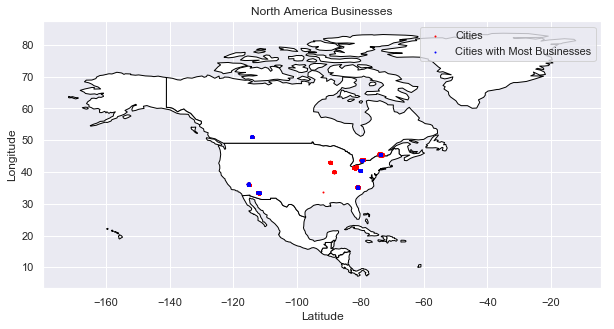

In [14]:
check = [x in top10cities for x in gdf['city']]
bigbuscities = gdf[check]

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(10, 7))

gdf.plot(ax=ax, color='red', markersize=1, label='Cities')
bigbuscities.plot(ax=ax, color='blue', markersize=1, label="Cities with Most Businesses")
ax.set_title("North America Businesses")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.legend()
plt.show()

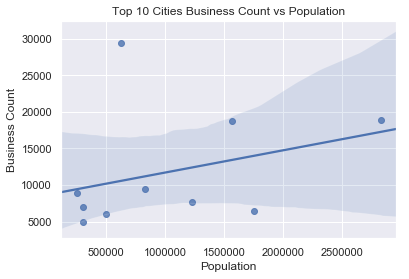

In [15]:
sns.regplot(top10['Population'], top10['Business Count'])
plt.title("Top 10 Cities Business Count vs Population")
plt.show()

The cities with the most businesses are in the middle of all the concentrated regions of businesses in this dataset.  But it doesn't seem like a larger number of businesses is correlated with a higher population in the city, just looking at the cities with the most businesses.  The reason for this is Las Vegas, which has an extremely high number of businesses but in comparison to the other top 10 cities, not a very high population.  This is mainly just due to Las Vegas being a very tourist oriented city. Therefore higher population does not mean a higher number of Yelp businesses in the city.

## 2.2. What are the most frequent business categories overall?

We will observe the top 20 most frequent business categories, and then look at the top five of them in more depth to understand what kind of businesses they detail.

The top 20 most frequent business categories are:

In [16]:
# Code for Question 2.2
allbuscats = []
for x in businessdat['categories']:
    if x is not None:
        data = x.split(',')
        for i in range(len(data)):
            data[i] = data[i].strip()
        allbuscats.extend(data)
        
allbuscats = pd.Series(allbuscats)
top20 = allbuscats.value_counts()[0:20]

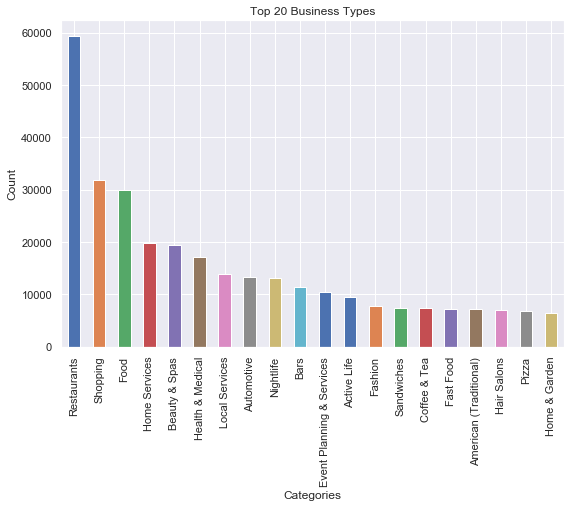

In [19]:
ax = top20.plot(kind='bar', figsize=(9, 6))
ax.set_title("Top 20 Business Types")
ax.set_xlabel("Categories")
ax.set_ylabel("Count")
plt.show()

Restaurants are the top business type for businesses in this dataset, with Shopping as second, Food as third, Home Services as fourth, and Beauty and Spas as fifth. These categories are pretty broad, and there is the mystery of why it appears that only half the Restaurants in this dataset serve food.  Therefore we will look at these top five categories in some more depth:

In [20]:
def getcats(category, data):
    categories = []
    for x in data['categories']:
        if x is not None:
            buscats = x.split(',')
            for i in range(len(buscats)):
                buscats[i] = buscats[i].strip()
            if category in buscats:
                buscats.remove(category)
                categories.extend(buscats)
    return pd.Series(categories)
            
rescats = getcats('Restaurants', businessdat)
top5rescounts = rescats.value_counts()[0:5]

shopcats = getcats('Shopping', businessdat)
top5shopcounts = shopcats.value_counts()[0:5]

foodcats = getcats('Food', businessdat)
top5foodcounts = foodcats.value_counts()[0:5]

homecats = getcats('Home Services', businessdat)
top5homecounts = homecats.value_counts()[0:5]

spacats = getcats('Beauty & Spas', businessdat)
top5spacounts = spacats.value_counts()[0:5]

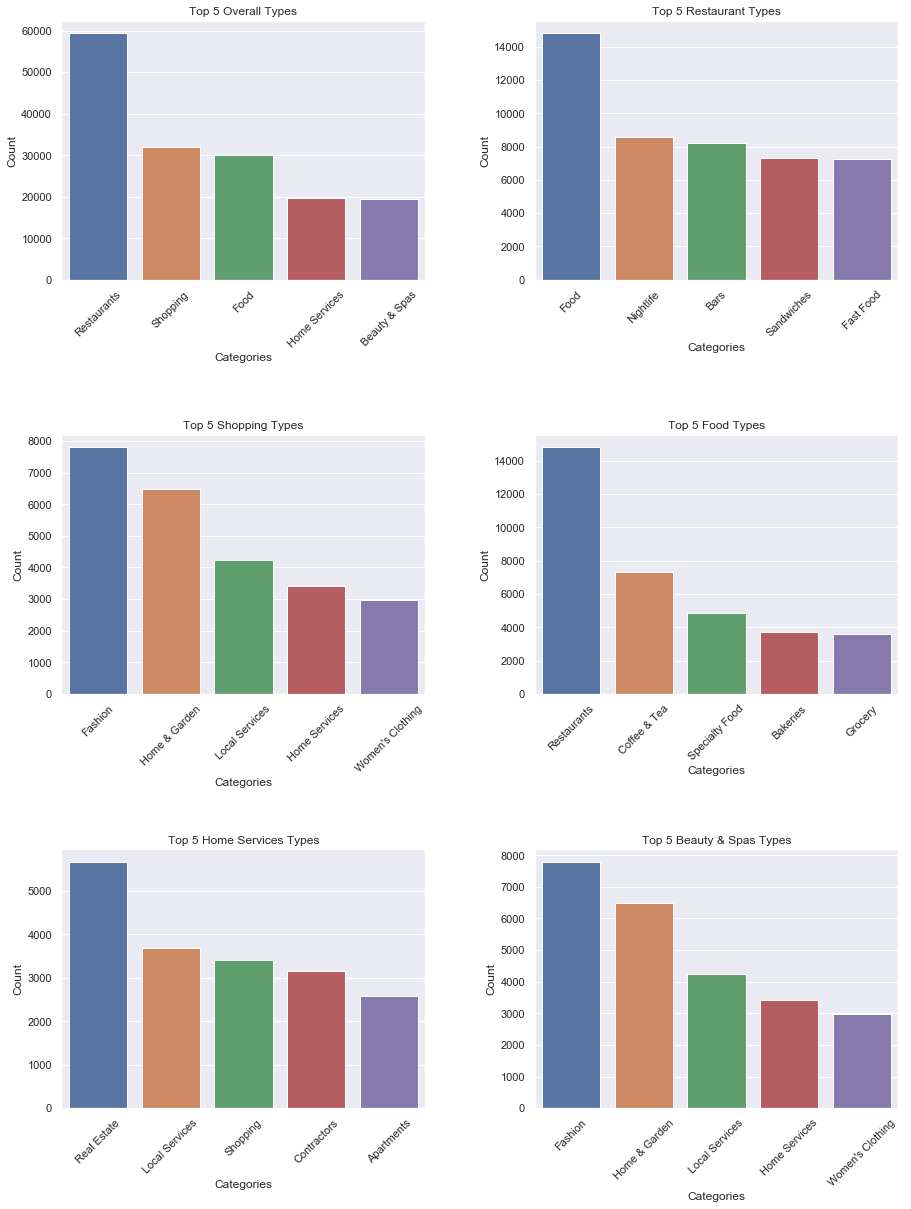

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

def barplotcats(data, row, col, name):
    sns.barplot(data.index, data.values, ax=axs[row, col])
    axs[row, col].set_title("Top 5 " + name + " Types")
    axs[row, col].set_xlabel('Categories')
    axs[row, col].set_ylabel('Count')
    
barplotcats(top20[0:5], 0, 0, "Overall")
barplotcats(top5rescounts, 0, 1, "Restaurant")
barplotcats(top5shopcounts, 1, 0, "Shopping")
barplotcats(top5foodcounts, 1, 1, "Food")
barplotcats(top5homecounts, 2, 0, "Home Services")
barplotcats(top5shopcounts, 2, 1, "Beauty & Spas")

for i in range(3):
    for j in range(2):
        plt.setp(axs[i, j].get_xticklabels(), rotation=45)

plt.show()

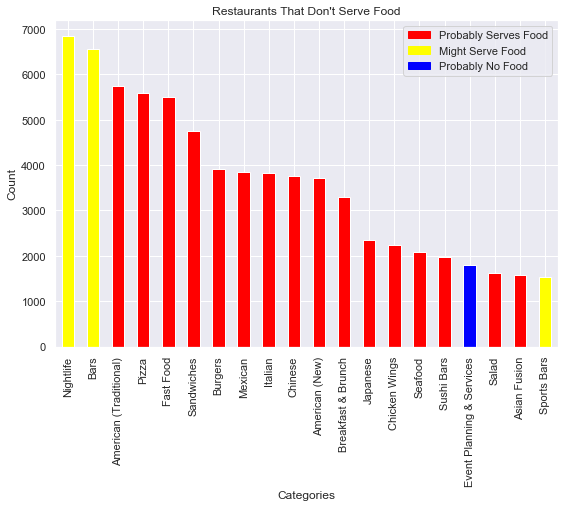

In [23]:
# Restaurants that don't serve food

def getcatswithout(category, exclude, data):
    categories = []
    for x in data['categories']:
        if x is not None:
            buscats = x.split(',')
            for i in range(len(buscats)):
                buscats[i] = buscats[i].strip()
            if category in buscats:
                if exclude not in buscats:
                    buscats.remove(category)
                    categories.extend(buscats)
    return pd.Series(categories)

color = ['yellow', 'yellow', 'red', 'red', 'red', 'red', 'red', 
         'red', 'red', 'red', 'red', 'red', 'red', 'red', 
         'red', 'red', 'blue', 'red', 'red', 'yellow']

red_patch = patches.Patch(color='red', label='Probably Serves Food')
yellow_patch = patches.Patch(color='yellow', label='Might Serve Food')
blue_patch = patches.Patch(color='blue', label='Probably No Food')

foodless = getcatswithout('Restaurants', 'Food', businessdat)
foodless = foodless.value_counts()[0:20]

ax = foodless.plot(kind='bar', figsize=(9, 6), color=color)
ax.set_title("Restaurants That Don't Serve Food")
ax.set_xlabel("Categories")
ax.set_ylabel("Count")
plt.legend(handles=[red_patch, yellow_patch, blue_patch])
plt.show()

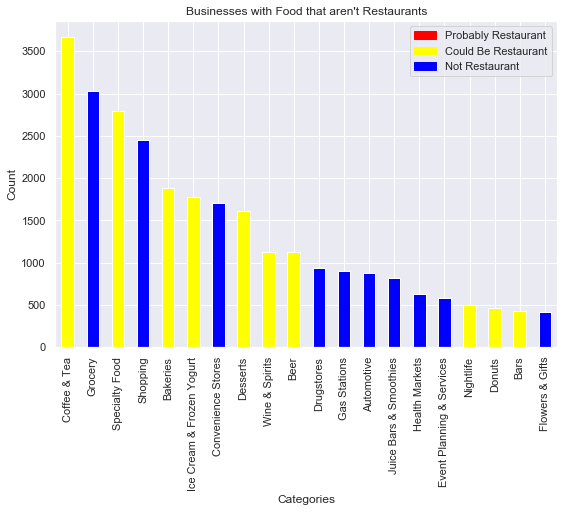

In [24]:
# Food that isn't in Restaurants
            
nores = getcatswithout('Food', 'Restaurants', businessdat)
nores = nores.value_counts()[0:20]

color = ['yellow', 'blue', 'yellow', 'blue', 'yellow', 'yellow', 'blue', 
         'yellow', 'yellow', 'yellow', 'blue', 'blue', 'blue', 'blue', 
         'blue', 'blue', 'yellow', 'yellow', 'yellow', 'blue']

red_patch = patches.Patch(color='red', label='Probably Restaurant')
yellow_patch = patches.Patch(color='yellow', label='Could Be Restaurant')
blue_patch = patches.Patch(color='blue', label='Not Restaurant')

ax = nores.plot(kind='bar', figsize=(9, 6), color=color)
ax.set_title("Businesses with Food that aren't Restaurants")
ax.set_xlabel("Categories")
ax.set_ylabel("Count")
plt.legend(handles=[red_patch, yellow_patch, blue_patch])
plt.show()

The categories 'Restaurant' and 'Food' are closely related.  The most frequent restaurant types are Nightlife, Bars, Sandwiches, and Fast Food.  The most frequent 'Food' types are Coffee & Tea, Specialty Food, Bakeries, and Groceries.  We can see that there are definitely places that sell food that are not restaurants, like cafes and grocery stores.  However, the distinction for restaurants that don't serve food seems limited to possibly just bars, and even then most bars have a food menu.  Then it seems logical to conclude that Restaurant is most likely a subset of Food, and not the other way around.

However, it seems that many business owners who use Yelp haven't realized this distinction for the categories, and many restaurants that do serve food just tag their business with the more specific type of food, rather than the 'Food' category itself. Meanwhile, it would be inaccurate for many places such as grocery stores to tag their business as 'Restaurant', but they definitely qualify under 'Food'.  As a result, it may be more accurate to say that 'Food' is the most frequent business category, while Restaurant is second.

The most frequent 'Shopping' types are Fashion, Home & Garden, Local Services, Home Services, and Women's Clothing.

The most frequent 'Home Services' types are Real Estate, Local Services, Shopping, Contractors, and Apartments.  The most frequent type of Home Services seems to refer to finding housing.

The most frequent 'Beauty & Spas' types are Hair Salons, Nail Salons, Hair Removal, Skin Care, and Health & Medical.

## 2.3. What types of establishments tend to have bike parking?

We will calculate the percentage of businesses that have bike parking for each category, then look at the top 20 most frequent business categories and compare their percentages.  Not all businesses in this dataset have the attribute "Bike Parking", so we assume any place that does not explicitely mention it does not have bike parking.  We are looking at the top 20 because if we looked at all categories, the business categories that have very few businesses have a much higher skewed percentage.

In [25]:
# Code for Question 2.3

# number of business of category that have bike parking
categories = allbuscats.value_counts()
bpcategories = allbuscats.value_counts().to_dict()
for x in bpcategories.keys():
    bpcategories[x] = 0
bpcategories

for i in range(len(businessdat)):
    attributes = businessdat.iloc[i]['attributes']
    if attributes is not None:
        if 'BikeParking' in list(attributes.keys()):
            if attributes['BikeParking'] == 'True':
                cats = businessdat.iloc[i]['categories'].split(', ')
                for cat in cats:
                    bpcategories[cat] = bpcategories[cat] + 1
        
bpcategories = pd.Series(bpcategories)

percentage = bpcategories / categories
percentage = percentage[categories[0:20].index].sort_values(ascending=False)

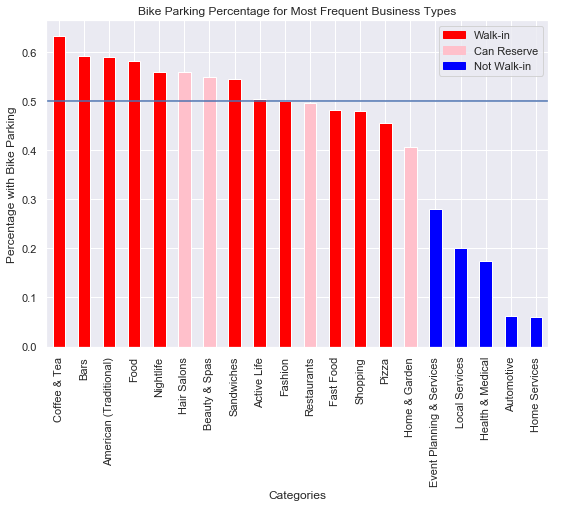

In [30]:
color = ['red', 'red', 'red', 'red', 'red', 'pink', 'pink', 
         'red', 'red', 'red', 'pink', 'red', 'red', 'red', 
         'pink', 'blue', 'blue', 'blue', 'blue', 'blue']

ax = percentage.plot(kind='bar', figsize=(9, 6), color = color)
ax.set_xlabel("Categories")
ax.set_ylabel("Percentage with Bike Parking")
ax.set_title("Bike Parking Percentage for Most Frequent Business Types")

red_patch = patches.Patch(color='red', label='Walk-in')
pink_patch = patches.Patch(color='pink', label='Can Reserve')
blue_patch = patches.Patch(color='blue', label='Not Walk-in')
plt.legend(handles=[red_patch, pink_patch, blue_patch])
plt.axhline(0.5)
plt.show()

We label the categories that most people just walk into to use their services as "Walk-in", the categories that people can walk into, but it's considered good manners to call and reserve beforehand "Can Reserve", and places that most people will call ahead of time to use their services as "Not Walk-in".

Here we can see that among the top 20 most frequent business categories, businesses with categories 'Coffee & Tea', 'Bars', and 'Food' have the highest percentage of bike parking.  Over 50% of Coffee & Tea, Bars, American (Traditional), Food, Nightlife, Hair Salons, Beauty & Spas, Sandwiches, and Active Life places in this dataset have bike parking.

As well, we can see that businesses that we can just "Walk-in" to have a much higher percentage of places with bike parking than places without.  Places that we "Can Reserve" but don't always do so also have bike parking but at a slightly lower percentage.  And places that most people will have to reserve services for beforehand have the lowest percentage of bike parking among these categories. This is probably because if you have to call ahead of time to reserve services, the place may be farther away from where they live so they have to drive to the business, or it's a more formal business that people drive their vehicles to.  

## 2.4. An article recently claimed that having more yelp reviews lead to a higher rating, and hence increased sales. Do the data support this claim?

We will see if there is an increasing relationship between review count and star rating.  We will try a linear regression model, and we will compare the means of the review count for each category of star rating.  We use the mean because we do want know which categories tend to have the very large review counts, so we want to take into account large outliers.

In [27]:
# Code for Question 2.4
import statsmodels.api as sm

X = businessdat['review_count']
X = sm.add_constant(X)
y = businessdat['stars']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     321.6
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           7.47e-72
Time:                        00:04:20   Log-Likelihood:            -2.7666e+05
No. Observations:              192609   AIC:                         5.533e+05
Df Residuals:                  192607   BIC:                         5.533e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5730      0.002   1474.101   

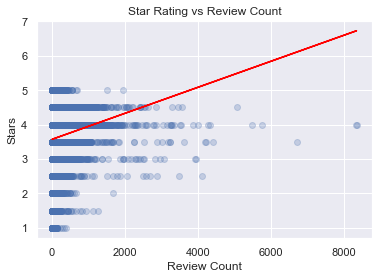

In [28]:
plt.scatter(businessdat['review_count'], businessdat['stars'], alpha=0.25)
plt.plot(businessdat['review_count'], results.params[0] + results.params[1]*businessdat['review_count'], color = 'red');
plt.title("Star Rating vs Review Count")
plt.xlabel("Review Count")
plt.ylabel("Stars")
plt.show()

We can see that there is somewhat of a positive relationship between Review Count and Stars.  However, a linear regression model doesn't work very well to examine the correlation between review count and star rating for businesses.  The line barely fits the data points, and the R-squared value is only 0.002, extremely small.  It does imply a positive correlation, but it isn't very trustworthy.

We examine the means of category of star rating, since star rating is finite.

In [29]:
print(businessdat.groupby('stars')['review_count'].mean())

stars
1.0     5.815552
1.5    15.596664
2.0    15.108874
2.5    20.910630
3.0    30.857286
3.5    40.681130
4.0    56.523228
4.5    43.444453
5.0    12.113942
Name: review_count, dtype: float64


We test to see if the mean of review counts is significantly different for different star ratings, by testing the means of each category and the one 0.5 stars higher.

In [31]:
# null hypothesis: having more yelp reviews has nothing to do with higher ratings
# alternate hypothesis: having more yelp reviews leads to higher ratings

cat10 = list(businessdat[businessdat['stars'] == 1.0]['review_count'])
cat15 = list(businessdat[businessdat['stars'] == 1.5]['review_count'])
cat20 = list(businessdat[businessdat['stars'] == 2.0]['review_count'])
cat25 = list(businessdat[businessdat['stars'] == 2.5]['review_count'])
cat30 = list(businessdat[businessdat['stars'] == 3.0]['review_count'])
cat35 = list(businessdat[businessdat['stars'] == 3.5]['review_count'])
cat40 = list(businessdat[businessdat['stars'] == 4.0]['review_count'])
cat45 = list(businessdat[businessdat['stars'] == 4.5]['review_count'])
cat50 = list(businessdat[businessdat['stars'] == 5.0]['review_count'])

In [32]:
import scipy.stats as stats

message = "t-test p-value for stars "
print(message + '1.0 and 1.5: ' + str(stats.ttest_ind(cat10, cat15, equal_var=False)[1]))
print(message + '1.5 and 2.0: ' + str(stats.ttest_ind(cat15, cat20, equal_var=False)[1]))
print(message + '2.0 and 2.5: ' + str(stats.ttest_ind(cat20, cat25, equal_var=False)[1]))
print(message + '2.5 and 3.0: ' + str(stats.ttest_ind(cat25, cat30, equal_var=False)[1]))
print(message + '3.0 and 3.5: ' + str(stats.ttest_ind(cat30, cat35, equal_var=False)[1]))
print(message + '3.5 and 4.0: ' + str(stats.ttest_ind(cat35, cat40, equal_var=False)[1]))
print(message + '4.0 and 4.5: ' + str(stats.ttest_ind(cat40, cat45, equal_var=False)[1]))
print(message + '4.5 and 5.0: ' + str(stats.ttest_ind(cat45, cat50, equal_var=False)[1]))

t-test p-value for stars 1.0 and 1.5: 5.03200542978842e-50
t-test p-value for stars 1.5 and 2.0: 0.4827022519507418
t-test p-value for stars 2.0 and 2.5: 1.4649101598717048e-20
t-test p-value for stars 2.5 and 3.0: 1.1008381059083963e-36
t-test p-value for stars 3.0 and 3.5: 8.088016636257389e-33
t-test p-value for stars 3.5 and 4.0: 1.3890578175346252e-48
t-test p-value for stars 4.0 and 4.5: 1.5014503528297853e-28
t-test p-value for stars 4.5 and 5.0: 0.0


In [33]:
# test for star ratings above and below 3.5
a35 = [x in [5.0, 4.5, 4.0, 3.5] for x in businessdat['stars']]
above35 = businessdat[a35]
b35 = [not x for x in a35]
below35 = businessdat[b35]

pval = stats.ttest_ind(above35['review_count'], below35['review_count'], equal_var=False)[1]
print('t-test p-value for mean of businesses with stars below 3.5 and above 3.5: ' + str(pval))

t-test p-value for mean of businesses with stars below 3.5 and above 3.5: 0.0


By our t-test results, we conclude that there is a significant increase in the mean of review counts between increasing star ratings for businesses, except between star rating 1.5 and 2.0, between star ratings 0 to 4.  Then a higher review count leads to a higher star count when the star rating is between 1 to 4.  Above 4.0, having a higher review count seems to lead to a lower star rating.  This could be thought of as if the business has such a high rating that people are no longer concerned with leaving reviews for the business.

As well, there is a difference in the mean of review counts between businesses that have a star count larger or equal to 3.5, and businesses that have a star count below 3.5. Then we can conclude that businesses with higher review counts tend to have higher star ratings.

# Question 3: Canadian businesses

In [12]:
## code for Question 3: Canadian businesses
canada = ['ON', 'QC', 'BC', 'AB', 'PE', 'NS', 'NB', 'MB', 'SK', 'YT', 'NT', 'NU', 'NL']
check = [x in canada for x in gdf['state']]
canbus = gdf[check]
canbus = canbus.reset_index(drop=True)

## 3.1. What cities does this dataset encompass?

We will graph all the cities in Canada present in this dataset, as well as note the cities in each province that have the most businesses present in them.

Provincial map data taken from [here](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/)

In [17]:
# cleaning some mispelled data
canbus.city = canbus.city.replace('North york', 'North York')
canbus.city = canbus.city.replace('Thornhil', 'Thornhill')
canbus.city = canbus.city.replace('Markham, ON', 'Markham')
canbus.city = canbus.city.replace('Tornto', 'Toronto')
canbus.city = canbus.city.replace('markham', 'Markham')
canbus.city = canbus.city.replace('Toronto Division', 'Toronto')
canbus.city = canbus.city.replace('Vaughan Mills', 'Vaughan')
canbus.city = canbus.city.replace('Vaughn', 'Vaughan')
canbus.city = canbus.city.replace('AGINCOURT', 'Agincourt')
canbus.city = canbus.city.replace('NorthYork', 'North York')
canbus.city = canbus.city.replace('Toronto-North York', 'North York')
canbus.city = canbus.city.replace('SCARBOROUGH', 'Scarborough')
canbus.city = canbus.city.replace('Etobicoke,', 'Etobicoke')
canbus.city = canbus.city.replace('North Toronto', 'Toronto')
canbus.city = canbus.city.replace('Woodbridge (Vaughan)', 'Vaughan')
canbus.city = canbus.city.replace('Thorncliff Park', 'East York')
canbus.city = canbus.city.replace('North  York', 'North York')
canbus.city = canbus.city.replace('Toronto-West', 'Toronto')
canbus.city = canbus.city.replace('THORNHILL', 'Thornhill')
canbus.city = canbus.city.replace('Richmonhill', 'Richmond Hill')
canbus.city = canbus.city.replace('Toronto-Etobicoke', 'Etobicoke')
canbus.city = canbus.city.replace('etobicoke', 'Etobicoke')
canbus.city = canbus.city.replace('Pickering Ajax Whitby', 'Ajax')
canbus.city = canbus.city.replace('Whtiby', 'Whitby')
canbus.city = canbus.city.replace('Richmond Hil', 'Richmond Hill')
canbus.city = canbus.city.replace('Mississauaga', 'Mississauga')
canbus.city = canbus.city.replace('Toronto Scarborough', 'Scarborough')
canbus.city = canbus.city.replace('Regional Municipality of York', 'North York')
canbus.city = canbus.city.replace('Mississauge', 'Mississauga')
canbus.city = canbus.city.replace('Mississagua', 'Mississauga')
canbus.city = canbus.city.replace('Scarobrough', 'Scarborough')
canbus.city = canbus.city.replace('Mississaugua', 'Mississauga')
canbus.city = canbus.city.replace('Northyork', 'North York')
canbus.city = canbus.city.replace('Whiitby', 'Whitby')
canbus.city = canbus.city.replace('Etibicoke', 'Etobicoke')
canbus.city = canbus.city.replace('Mississuaga', 'Mississauga')
canbus.city = canbus.city.replace('East Ajax', 'Ajax')
canbus.city = canbus.city.replace('Etobicoke', 'Toronto')

# clean Quebec values
canbus.city = canbus.city.replace('MontrÃ©al', 'Montreal')

# clean Alberta values
canbus.city = canbus.city.replace('CALGARY', 'Calgary')
canbus.city = canbus.city.replace('SW Calgary', 'Calgary')
canbus.city = canbus.city.replace('Northeast Calgary', 'Calgary')
canbus.city = canbus.city.replace('Northwest Calgary', 'Calgary')
canbus.city = canbus.city.replace('Southeast Calgary', 'Calgary')
canbus.city = canbus.city.replace('calgary', 'Calgary')

# the one BC value is actually located in Richmond Hill
canbus.state = canbus.state.replace('BC', 'ON')

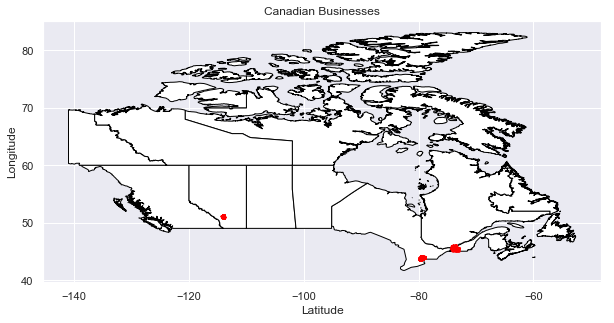

In [36]:
provinces = gp.read_file('data/canada/ne_10m_admin_1_states_provinces.shp')
canada = provinces[provinces['geonunit'] == 'Canada']

# Plot canada
ax = canada.plot(
    color='white', edgecolor='black', figsize=(10, 10))

canbus.plot(ax=ax, color='red', markersize=1)
ax.set_title("Canadian Businesses")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
plt.show()

In [14]:
t = pd.DataFrame()

t["Alberta Cities"] = canbus[canbus['state'] == 'AB']['city'].value_counts()[0:10].index
t["Alberta Counts"] = canbus[canbus['state'] == 'AB']['city'].value_counts()[0:10].values
t["Ontario Cities"] = canbus[canbus['state'] == 'ON']['city'].value_counts()[0:10].index
t["Ontario Counts"] = canbus[canbus['state'] == 'ON']['city'].value_counts()[0:10].values
t["Quebec Cities"] = canbus[canbus['state'] == 'QC']['city'].value_counts()[0:10].index
t["Quebec Counts"] = canbus[canbus['state'] == 'QC']['city'].value_counts()[0:10].values
display(t[['Alberta Cities', 'Alberta Counts', 'Ontario Cities', 'Ontario Counts']])
display(t[['Quebec Cities', 'Quebec Counts']])

,Alberta Cities,Alberta Counts,Ontario Cities,Ontario Counts
0,Calgary,7745,Toronto,19705
1,Airdrie,168,Mississauga,3117
2,Chestermere,31,Markham,1768
3,Rocky View,20,North York,1210
4,Balzac,11,Scarborough,1106
5,Rocky View County,9,Richmond Hill,1028
6,Rocky View No. 44,4,Brampton,1002
7,Division No. 6,3,Vaughan,922
8,Rockyview,2,Thornhill,397
9,Edmonton,2,Oakville,362


,Quebec Cities,Quebec Counts
0,Montreal,6601
1,Laval,394
2,Brossard,177
3,Verdun,153
4,Saint-Laurent,136
5,Pointe-Claire,102
6,Dorval,97
7,Westmount,97
8,Dollard-des-Ormeaux,87
9,Longueuil,78


From the map, we can see that the Canadian businesses in this dataset are all from three concentrated regions in Alberta, Ontario, and Quebec.  The table shows the top 10 cities with the most businesses in the dataset for each of the three provinces.  The overwhelming majority of businesses are from Ontario, and then Quebec, and then Alberta.

## 3.2. Identify the larger metropolitan regions that these cities belong to.

We will gather information about the metropolitan regions of canada from the Statistics Canada website, then use it to create a new variable in the dataframe that represents the region the business is in.

In [22]:
# website with metropolitan regions written in it
webpage = 'http://www23.statcan.gc.ca/imdb/p3VD.pl?Function=' + \
          'getVDStruct&TVD=314312&CVD=314313&CPV=A&CST=01012016&CLV=1&MLV=3'
page = urlopen(webpage)
soup = BeautifulSoup(page, 'html.parser')

test = soup.select('ul')
test = test[4]

check = str(test).split('li class')[2:]

regiondict = {}
newkey = ''
for x in check:
    if "indent-2" in x:
        newkey = x.split('>')[2].split('<')[0].split(' - ')[1]
        newkey = newkey.replace('é', 'e')
        newkey = newkey.replace('è', 'e')
        newkey = newkey.replace('ê', 'e')
        regiondict[newkey] = []
    else:
        newcity = x.split('>')[1].split('<')[0].split(' - ')[1]
        newcity = newcity.replace('é', 'e')
        newcity = newcity.replace('è', 'e')
        newcity = newcity.replace('ê', 'e')
        regiondict[newkey].append(newcity)
regiondict['Toronto'].append('Etobicoke')

In [23]:
webpage = 'https://en.wikipedia.org/wiki/List_of_census_metropolitan_areas_and_agglomerations_in_Canada'
scraped = pd.read_html(webpage)
metro_pop = scraped[0]
metro_pop = metro_pop.drop(columns=[0, 1, 4, 6, 7])
metro_pop = metro_pop.rename(columns={2: 'Geographic Name', 3: 'Province', 5: 'Population'})
metro_pop = metro_pop[1:].reset_index(drop=True)
for i in range(len(metro_pop)):
    metro_pop.loc[i, 'Geographic Name'] = metro_pop.loc[i, 'Geographic Name'].split(' (')[0]

def getPopulation(metro):
    pop = metro_pop[metro_pop['Geographic Name'] == metro]['Population']
    if len(pop) > 0:
        return pop.values[0]
    else:
        return 0

In [24]:
def findregion(city):
    for key in regiondict.keys():
        if city in regiondict[key]:
            return key

canbus['region'] = [findregion(x) for x in canbus['city']]
data = canbus['region'].value_counts()
regions = pd.DataFrame(data)
regions = regions.reset_index()
regions = regions.rename(columns = {'index': 'Area', 'region': 'Business Count'})
regions['Population'] = [getPopulation(x) for x in regions['Area']]
regions.loc[8, 'Population'] = 800296
regions.loc[7, 'Population'] = 523894
regions['Population'] = [int(x) for x in regions['Population']]
display(regions)

,Area,Business Count,Population
0,Toronto,29315,5928040
1,Montreal,8051,4098927
2,Calgary,7953,1392609
3,Oshawa,279,379848
4,Windsor,19,329144
5,Hamilton,2,747545
6,Edmonton,2,1321426
7,Kitchener--Cambridge--Waterloo,1,523894
8,Quebec,1,800296


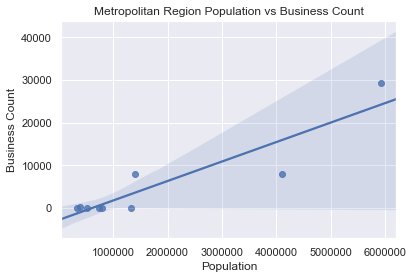

In [44]:
sns.regplot(regions['Population'], regions['Business Count'])
plt.title("Metropolitan Region Population vs Business Count")
plt.show()

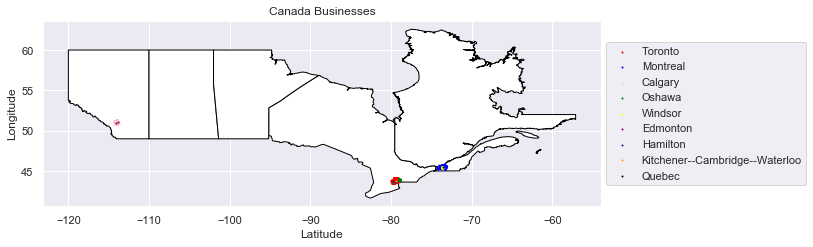

In [45]:
# colour canada map by region
isolate = ['Alberta', 'Manitoba', 'Saskatchewan', 'QuÃ©bec', 'Ontario']
check = [x in isolate for x in canada['name']]

ax = canada[check].plot(color='white', edgecolor='black', figsize=(10, 10))

canbus[canbus['region'] == 'Toronto'].plot(ax=ax, color='red', markersize=1, label='Toronto')
canbus[canbus['region'] == 'Montreal'].plot(ax=ax, color='blue', markersize=1, label='Montreal')
canbus[canbus['region'] == 'Calgary'].plot(ax=ax, color='pink', markersize=1, label='Calgary')
canbus[canbus['region'] == 'Oshawa'].plot(ax=ax, color='green', markersize=1, label='Oshawa')
canbus[canbus['region'] == 'Windsor'].plot(ax=ax, color='yellow', markersize=1, label='Windsor')
canbus[canbus['region'] == 'Edmonton'].plot(ax=ax, color='purple', markersize=1, label='Edmonton')
canbus[canbus['region'] == 'Hamilton'].plot(ax=ax, color='indigo', markersize=1, label='Hamilton')
canbus[canbus['region'] == 'Kitchener--Cambridge--Waterloo'].plot(ax=ax, 
                                                                  color='orange', 
                                                                  markersize=1, 
                                                                  label='Kitchener--Cambridge--Waterloo')
canbus[canbus['region'] == 'Quebec'].plot(ax=ax, color='black', markersize=1, label='Quebec')
ax.set_title("Canada Businesses")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

There are 9 metropolitan regions that can be identified in this dataset, spread across three provinces.  The largest is the Greater Toronto Area, and the smallest is the Quebec and Waterloo regions.  

Ontario has five metropolitan regions in this dataset: the GTA, Oshawa, Windsor, Hamilton, and Kitchener--Cambridge--Waterloo.

Quebec has two metropolitan regions in this dataset: Montreal and Quebec.

Alberta has two metropolitan regions in this dataset: Calgary and Edmonton.

While Toronto, Montreal, and Calgary have the overall largest number of businesses and largest population in their area, the remaining areas don't have a visible trend between the number of businesses and the population in their area. It is likely then that Yelp chose to include businesses in the Toronto, Montreal, and Calgary areas, along with more businesses close to these areas for this dataset.

# Question 4: GTA businesses

In [25]:
gtabus = canbus[canbus['region'] == 'Toronto']
gtabus = gtabus.reset_index(drop=True)

# fix typo
gtabus.name = gtabus.name.replace("Tim Horton's", 'Tim Hortons')

## 4.1. What are the most frequent business categories? How do they compare against the trends listed in 2.2?

We will count the most frequent business categories in the GTA region, and compare them with the overall most frequent business categories

In [47]:
gtabuscats = []
for x in gtabus['categories']:
    if x is not None:
        data = x.split(',')
        for i in range(len(data)):
            data[i] = data[i].strip()
        gtabuscats.extend(data)
        
gtabuscats = pd.Series(gtabuscats)

In [48]:
t = pd.DataFrame()

t["GTA Top Categories"] = gtabuscats.value_counts().index[0:10]
t["Overall Top Categories"] = top20.index[0:10]
display(t)

,GTA Top Categories,Overall Top Categories
0,Restaurants,Restaurants
1,Food,Shopping
2,Shopping,Food
3,Beauty & Spas,Home Services
4,Nightlife,Beauty & Spas
5,Bars,Health & Medical
6,Coffee & Tea,Local Services
7,Health & Medical,Automotive
8,Event Planning & Services,Nightlife
9,Chinese,Bars


We can see that Restaurants, Food, Shopping, Beauty & Spas, Health & Medical, Nightlife, and Bars are in the top 10 most frequent business categories for both the GTA and overall, although Nightlife and Bars are more frequent than Health & Medical in the GTA, while the opposite holds overall.

In the GTA, Coffee & Tea, Event Planning & Services, and Chinese are some of the most frequent business categories that aren't part of the top 10 overall.

Overall, Home Services, Local Services, Automotive are more prominent than in the GTA.

We will look at the most popular subcategories for Restaurants, Food, Shopping, and Beauty & Spas to see if there is a difference in their distribution from the overall businesses.

In [49]:
rescats = getcats('Restaurants', gtabus)
gtarescounts = rescats.value_counts()[0:5]

foodcats = getcats('Food', gtabus)
gtafoodcounts = foodcats.value_counts()[0:5]

shopcats = getcats('Shopping', gtabus)
gtashopcounts = shopcats.value_counts()[0:5]

spacats = getcats('Beauty & Spas', gtabus)
gtaspacounts = spacats.value_counts()[0:5]

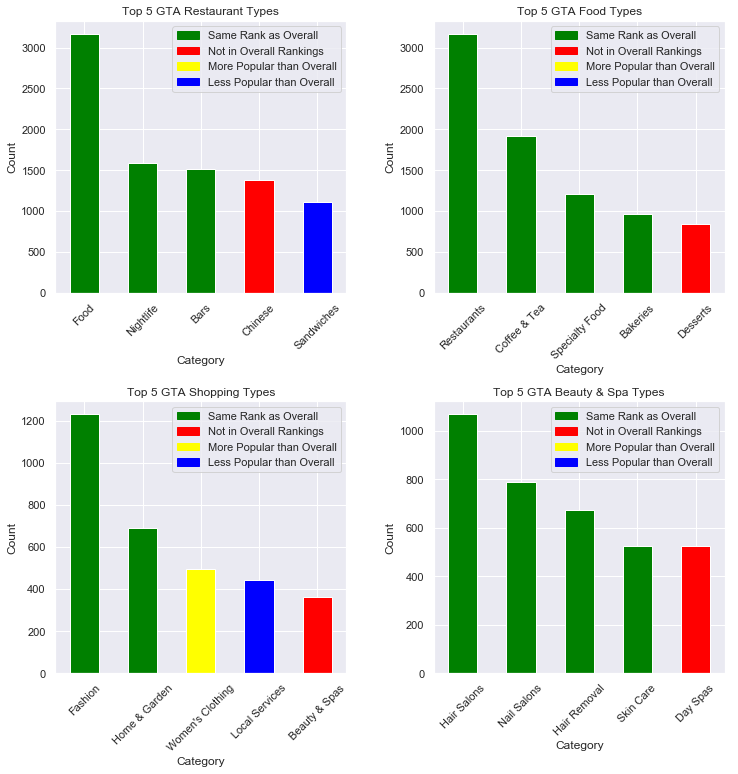

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

red_patch = patches.Patch(color='red', label='Not in Overall Rankings')
yellow_patch = patches.Patch(color='yellow', label='More Popular than Overall')
green_patch = patches.Patch(color='green', label='Same Rank as Overall')
blue_patch = patches.Patch(color='blue', label='Less Popular than Overall')

def barplotcats(data, color, row, col, title):
    data.plot(kind='bar', color=color, ax=axs[row, col])
    axs[row, col].legend(handles=[green_patch, red_patch, yellow_patch, blue_patch])
    axs[row, col].set_title("Top 5 GTA " + title + " Types")
    axs[row, col].set_xlabel("Category")
    axs[row, col].set_ylabel("Count")


color = ['green', 'green', 'green', 'red', 'blue']
barplotcats(gtarescounts, color, 0, 0, "Restaurant")

color = ['green', 'green', 'green', 'green', 'red']
barplotcats(gtafoodcounts, color, 0, 1, "Food")

color = ['green', 'green', 'yellow', 'blue', 'red']
barplotcats(gtashopcounts, color, 1, 0, "Shopping")

color = ['green', 'green', 'green', 'green', 'red']
barplotcats(gtaspacounts, color, 1, 1, "Beauty & Spa")

for i in range(2):
    for j in range(2):
        plt.setp(axs[i, j].get_xticklabels(), rotation=45)

plt.show()

In [48]:
print("The number of businesses overall is:", len(businessdat))
print("The number of businesses in the GTA is:", len(gtabus))
print("The proportion of businesses that are in the GTA is:", len(gtabus) / len(businessdat))

The number of businesses overall is: 192609
The number of businesses in the GTA is: 29315
The proportion of businesses that are in the GTA is: 0.1521995337704884


Looking at the graph of the top subcategories in each of the four largest categories in the GTA, we can see that the most popular subcategories are very similar, with the lower ranked categories varying slightly.  The first and second most popular subcategories are identical for all four of these categories.  The lower three are slightly different from the Overall most popular subcategories, and there's always one subcategory in the top 5 for GTA that isn't in the Overall top 5. 

## 4.2. What are the top franchises in the city?

We will count the top 10 franchises that have the most businesses present in the GTA, the top 10 franchises that have the most businesses and also have star ratings 3.5 or above, and the top 10 franchises with the most reviews overall.

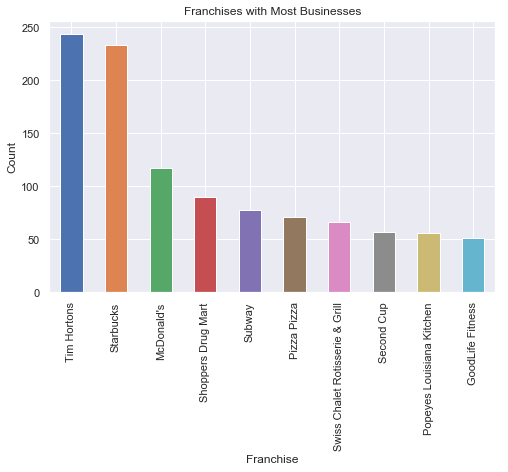

In [26]:
# franchises with most businesses
franchises = gtabus['name'].value_counts()
byamount = franchises[0:10]
ax = byamount.plot(kind='bar', figsize=(8, 5))
ax.set_title("Franchises with Most Businesses")
ax.set_xlabel("Franchise")
ax.set_ylabel("Count")
plt.show()

Notably, all of these businesses except for Shoppers Drug Mart, Swiss Chalet, and GoodLife Fitness are fast food/drink places.

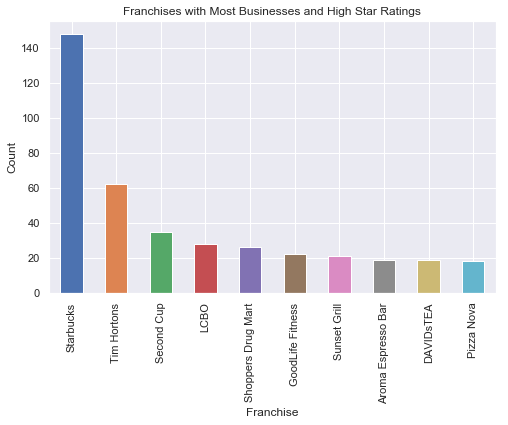

In [27]:
# highest ranked franchises with the most businesses
check = [x in [3.5, 4, 4.5, 5] for x in gtabus['stars']]
byamountstars = gtabus[check]['name'].value_counts()[0:10]
ax = byamountstars.plot(kind='bar', figsize=(8, 5))
ax.set_title("Franchises with Most Businesses and High Star Ratings")
ax.set_xlabel("Franchise")
ax.set_ylabel("Count")
plt.show()

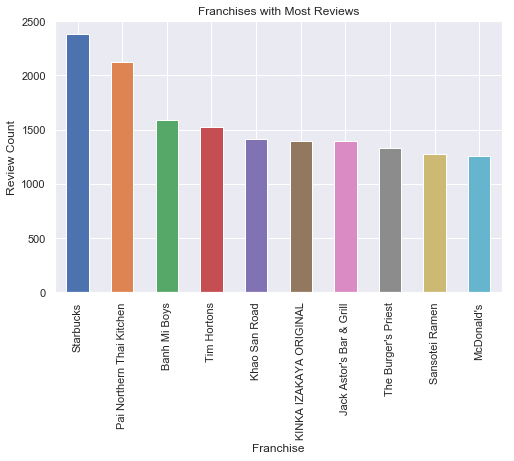

In [29]:
keys = franchises.index
reviewcount = {}
for key in keys:
    reviewcount[key] = 0

for i in range(len(gtabus)):
    name = gtabus.loc[i]['name']
    reviewcount[name] = reviewcount[name] + gtabus.loc[i]['review_count']
    
byreviews = pd.Series(reviewcount).sort_values(ascending=False)[0:10]
ax = byreviews.plot(kind='bar', figsize=(8, 5))
ax.set_title("Franchises with Most Reviews")
ax.set_xlabel("Franchise")
ax.set_ylabel("Review Count")
plt.show()

In [30]:
t = pd.DataFrame()

t["Top By Amount"] = byamount.index
t["Top Rated By Amount"] = byamountstars.index
t["Top By Reviews"] = byreviews.index

def highlight_overlap(s):
    return ['background-color: yellow' if v == 'Tim Hortons'
            else 'background-color: pink' if v == 'Starbucks'
            else 'background-color: red' if v == "McDonald's"
            else 'background-color: purple' if v == 'Second Cup'
            else 'background-color: blue' if v == 'GoodLife Fitness'
            else 'background-color: green' if v == 'Shoppers Drug Mart'
            else '' 
            for v in s]

# does not work in pdf conversion
t.style.apply(highlight_overlap)

# display(t)

,Top By Amount,Top Rated By Amount,Top By Reviews
0,Tim Hortons,Starbucks,Starbucks
1,Starbucks,Tim Hortons,Pai Northern Thai Kitchen
2,McDonald's,Second Cup,Banh Mi Boys
3,Shoppers Drug Mart,LCBO,Tim Hortons
4,Subway,Shoppers Drug Mart,Khao San Road
5,Pizza Pizza,GoodLife Fitness,KINKA IZAKAYA ORIGINAL
6,Swiss Chalet Rotisserie & Grill,Sunset Grill,Jack Astor's Bar & Grill
7,Second Cup,Aroma Espresso Bar,The Burger's Priest
8,Popeyes Louisiana Kitchen,DAVIDsTEA,Sansotei Ramen
9,GoodLife Fitness,Pizza Nova,McDonald's


When looking at the top 10 franchises just by the amount of businesses that they have in the Greater Toronto Area, Tim Hortons is first with Starbucks second by a small difference, and both of these two franchises have much more businesses than the other eight following franchises.  The large majority of these businesses are also fast food/drink locations.

When we look at the top 10 franchises that also have a star rating equal or above 3.5, Starbucks has an overwhelming lead over Tim Hortons and all other franchises.

As well, when looking at the top 10 franchises by number of reviews for all their businesses, Starbucks is still in the lead, and many new franchises get second and third, while Tim Hortons is only fourth.  

Starbucks seems to be the most consistently popular across these three ranking methods.  Tim Hortons has more franchises, but it seems to be of lesser quality than the Starbucks in the GTA, since it has less higher ranked businesses and less reviews.  

McDonalds also has many franchises, but isn't even in the top ten for businesses with high ratings, and is ranked tenth for review count.  This does seem to imply that while McDonalds is a large franchise, it isn't of very good quality, service or foodwise.  

## 4.3. Does business location play an important role in reviews?

We will investigate where businesses with high review counts are located in relation to all businesses, and businesses with high ratings are located in relation to all the businesses, since high ratings are correlated with high review count.  We will also investigate where businesses with popular reviews are located in relation to all the businesses.

Greater Toronto Area map data taken from [here](https://mdl.library.utoronto.ca/collections/geospatial-data/canmap-routelogistics-toronto-cma-subset-1)

In [55]:
# get all reviews that has to do with gta businesses
gtabusids = set(gtabus['business_id'])

reviewdict = {}

def createdict(row):
    for item in row.keys():
        reviewdict[item] = [row[item]]

def dictintodict(row):
    for item in row.keys():
        reviewdict[item].append(row[item])

with open("data/review.json", encoding="utf8") as f:
    for line in f:
        data = json.loads(line)
        if data['business_id'] in gtabusids:
            if reviewdict == {}:
                createdict(data)
            else:
                dictintodict(data)

reviewdat = pd.DataFrame(reviewdict)

# create new column for popular reviews
reviewdat['popularity'] = reviewdat['useful'] + reviewdat['funny'] + reviewdat['cool']

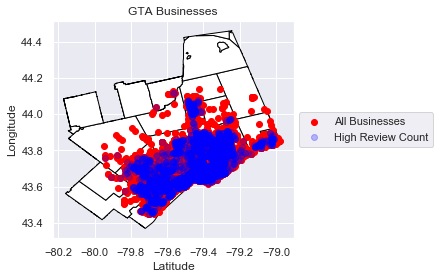

In [56]:
# businesses with a review count above the 75th percentile
gta = gp.read_file('data/ONmaf/ONmaf.shp')

ax = gta.plot(color='white', edgecolor='black')
gtabus.plot(ax=ax, color='red', label='All Businesses')
gtabus[gtabus['review_count'] >= gtabus['review_count'].quantile(0.75)].plot(ax=ax, 
                                                                             color='blue', 
                                                                             alpha=0.25, 
                                                                             label='High Review Count')
ax.set_title("GTA Businesses")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can see that businesses with high review counts are concentrated in areas with lots of businesses.

In [57]:
webpage = 'https://en.wikipedia.org/wiki/List_of_municipalities_in_the_Greater_Toronto_Area'
scraped = pd.read_html(webpage)
ontario_pop = scraped[0]
ontario_pop = ontario_pop.drop(columns=[1, 2, 3, 5])[1:]
ontario_pop = ontario_pop.reset_index(drop=True)
ontario_pop = ontario_pop.rename(columns={0: 'City', 4: 'Population'})

def findpop(city):
    this = ontario_pop[ontario_pop['City'] == city]['Population']
    if len(this) > 0:
        return int(this.values)
    else:
        return 0

In [58]:
cities = gtabus.groupby('city').mean().sort_values(by='review_count')
cities = cities[['review_count', 'stars']]
cities['count'] = gtabus['city'].value_counts()
cities = cities.reset_index()
cities['Population'] = [findpop(x) for x in cities['city']]
cities.loc[0, 'Population'] = 34242
cities.loc[5, 'Population'] = 35325
cities.loc[15, 'Population'] = 35325

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     491.3
Date:                Sat, 09 Mar 2019   Prob (F-statistic):           1.62e-14
Time:                        00:39:56   Log-Likelihood:                -162.06
No. Observations:                  20   AIC:                             328.1
Df Residuals:                      18   BIC:                             330.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -498.1047    208.216     -2.392      0.0

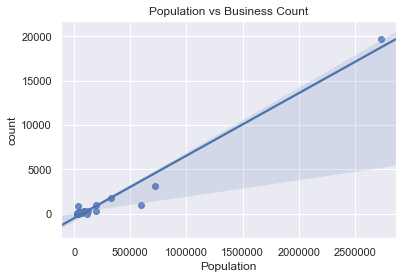

In [59]:
X = cities['Population']
X = sm.add_constant(X)
y = cities['count']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
sns.regplot(x='Population', y='count', data = cities)
plt.title("Population vs Business Count")
plt.show()

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     9.285
Date:                Sat, 09 Mar 2019   Prob (F-statistic):            0.00694
Time:                        00:39:57   Log-Likelihood:                -61.526
No. Observations:                  20   AIC:                             127.1
Df Residuals:                      18   BIC:                             129.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0408      1.366      8.081      0.0

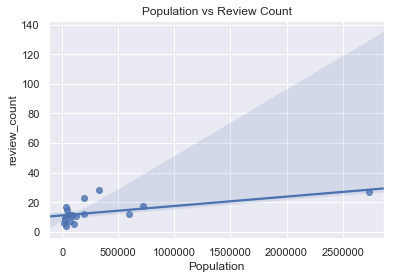

In [60]:
X = cities['Population']
X = sm.add_constant(X)
y = cities['review_count']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
sns.regplot(x='Population', y='review_count', data = cities)
plt.title("Population vs Review Count")
plt.show()

                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     9.445
Date:                Sat, 09 Mar 2019   Prob (F-statistic):            0.00655
Time:                        00:39:57   Log-Likelihood:                -61.467
No. Observations:                  20   AIC:                             126.9
Df Residuals:                      18   BIC:                             128.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5063      1.304      8.825      0.0

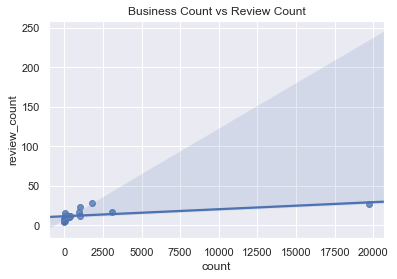

In [61]:
X = cities['count']
X = sm.add_constant(X)
y = cities['review_count']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
sns.regplot(x='count', y='review_count', data = cities)
plt.title("Business Count vs Review Count")
plt.show()

While there is a very good correlation between the population of a city and the amount of businesses in this dataset, the correlation between average review count and number of businesses is much weaker.  However, even though its R-squared value is just 0.340 and 0.344 for the linear regression between amount of businesses and review count, and population and review count respectively, the confidence interval still implies a very strong possibility of there being a positive correlation between them.

Therefore location most likely does affect the review count of businesses.  Cities with higher populations and higher number of businesses tend to have slightly higher average review counts on their businesses.  This could be implying that a higher population in a city leads to more people reviewing the businesses there.

In [62]:
# count popularity of reviews for businesses
# NOTE: takes around 5 minutes to run
nonzeropop = reviewdat[reviewdat['popularity'] > 0]
nonzeropop = nonzeropop.reset_index(drop = True)

gtabus['review popularity'] = [0 for x in gtabus['review_count']]
idgtabus = gtabus.set_index('business_id')

for i in range(len(nonzeropop)):
    bus_id = nonzeropop.loc[i]['business_id']
    idgtabus.loc[bus_id, 'review popularity'] = idgtabus.loc[bus_id, 'review popularity'] + nonzeropop.loc[i]['popularity']
    
gtabus = idgtabus.reset_index()

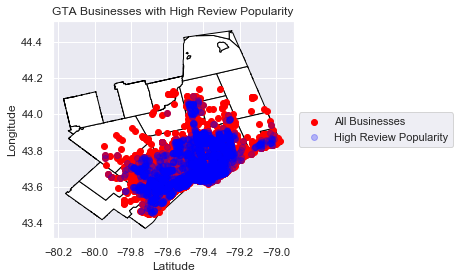

In [63]:
# businesses with an overall review popularity above 75th percentile
ax = gta.plot(color='white', edgecolor='black')
gtabus.plot(ax=ax, color='red', label='All Businesses')
gtabus[gtabus['review popularity'] >= gtabus['review popularity'].quantile(0.75)].plot(ax=ax, 
                                                                                       color='blue', 
                                                                                       alpha=0.25,
                                                                                       label='High Review Popularity')
ax.set_title("GTA Businesses with High Review Popularity")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [64]:
check = []
for i in range(len(gtabus)):
    average = 0
    if gtabus.loc[i, 'review_count'] > 0:
        average = gtabus.loc[i, 'review popularity'] / gtabus.loc[i, 'review_count']
    check.append(average)

gtabus['average review pop'] = check

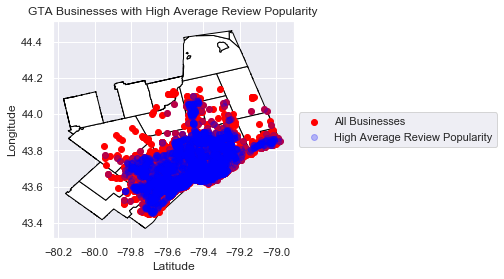

In [65]:
# businesses with an overall review popularity above 75th percentile
ax = gta.plot(color='white', edgecolor='black')
gtabus.plot(ax=ax, color='red', label='All Businesses')
arp_graph = gtabus[gtabus['average review pop'] >= gtabus['average review pop'].quantile(0.75)]
arp_graph.plot(ax=ax, color='blue', alpha=0.25, label='High Average Review Popularity')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
ax.set_title("GTA Businesses with High Average Review Popularity")
plt.show()

In [66]:
cities = gtabus.groupby('city').mean().sort_values(by='review popularity')
cities = cities[['review popularity', 'average review pop']]
cities['count'] = gtabus['city'].value_counts()
cities = cities.reset_index()
cities['Population'] = [findpop(x) for x in cities['city']]
cities.loc[0, 'Population'] = 34242
cities.loc[1, 'Population'] = 35325

                            OLS Regression Results                            
Dep. Variable:      review popularity   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     6.949
Date:                Sat, 09 Mar 2019   Prob (F-statistic):             0.0168
Time:                        00:47:51   Log-Likelihood:                -84.099
No. Observations:                  20   AIC:                             172.2
Df Residuals:                      18   BIC:                             174.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4521      4.265      5.733      0.0

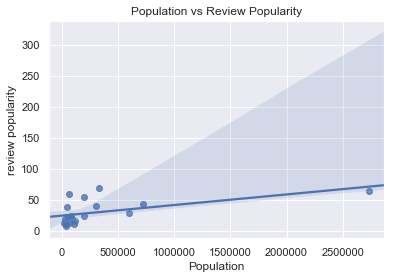

In [67]:
X = cities['Population']
X = sm.add_constant(X)
y = cities['review popularity']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
sns.regplot(x='Population', y='review popularity', data = cities)
plt.title("Population vs Review Popularity")
plt.show()

                            OLS Regression Results                            
Dep. Variable:     average review pop   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.434
Date:                Sat, 09 Mar 2019   Prob (F-statistic):             0.0803
Time:                        00:47:51   Log-Likelihood:                -17.122
No. Observations:                  20   AIC:                             38.24
Df Residuals:                      18   BIC:                             40.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0622      0.150     13.765      0.0

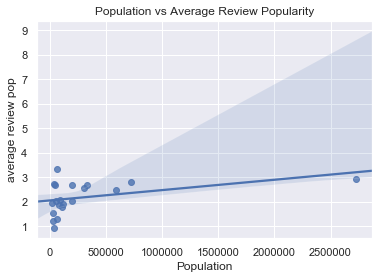

In [68]:
X = cities['Population']
X = sm.add_constant(X)
y = cities['average review pop']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
sns.regplot(x='Population', y='average review pop', data = cities)
plt.title("Population vs Average Review Popularity")
plt.show()

We define "Review Popularity" as the number of 'useful', 'funny', and 'cool' votes given to the review, and the business's overall review popularity as the sum of all its reviews' popularities.  This is a measure of how often users will seriously read other user's reviews given to this business.  Looking at the graph of the locations of businesses that have high review popularities, and the graph of the locations of businesses that have a high average review popularity, we see that these businesses are clustered in the middle of where all the businesses are located.  

We also conducted a linear regression for the population of a city and the review popularity of a business, as well as the population of a city vs the average review popularity of a business.  From the linear regression, we see that there is a somewhat positive correlation between the review popularity of a business and the population of the city its in.

However, there doesn't seem to be a conclusive correlation between the average review popularity and the population of the city the business is in.  The R-squared value is very small at 0.160, we can see that the regression line doesn't fit the data very well, and the confidence interval for the slope has both negative and positive values in it, so we cannot conclude a positive correlation.  Therefore we cannot conclude that businesses located in higher populated cities get more votes on their reviews per review, just that they get more votes on their reviews overall.  And since from our previous results we concluded that businesses in higher populated cities tend to have more reviews, we can conclude that while the average ratings per review doesn't seem to be correlated with city population, the businesses located in higher populated cities will have more reviews, and as a result the over ratings for reviews for those businesses are higher than those businesses with less reviews.

From this we conclude that businesses located in areas with more businesses and more populated areas have higher review counts, and higher amounts of people who read and rate the business's reviews.

## 4.4. Is it true that for every Tim Hortons in the GTA there is a Starbucks nearby? Calculate distances between establishments of the two groups and assess distance patterns. Plot the two types of establishments on a map.

We will define 'nearby' as within 1 kilometre, and 'kind of near' as within 2 kilometres.  Then we will calculate the distance to the nearest Starbucks for every Tim Hortons.

In [69]:
timhortons = gtabus[gtabus['name'] == 'Tim Hortons']
starbucks = gtabus[gtabus['name'] == 'Starbucks']
timhortons = timhortons.reset_index(drop=True)
starbucks = starbucks.reset_index(drop=True)

def coordinates(i, data):
    # return tuple
    x = data.loc[i]['latitude']
    y = data.loc[i]['longitude']
    return (x, y)

timhortons['coordinates'] = [coordinates(i, timhortons) for i in range(len(timhortons))]
starbucks['coordinates'] = [coordinates(i, starbucks) for i in range(len(starbucks))]

In [70]:
from geopy import distance

def findneareststarbucks(th_coor):
    min_dis = 0
    minsb = 0
    for i in range(len(starbucks)):
        if i == 0:
            location = starbucks.loc[i]['coordinates']
            min_dis = distance.distance(th_coor, location).km
        else:
            location = starbucks.loc[i]['coordinates']
            dist = distance.distance(th_coor, location).km
            if dist < min_dis:
                min_dis = dist
                minsb = i
    return min_dis

timhortons['nearest_starbucks'] = [findneareststarbucks(x) for x in timhortons['coordinates']]

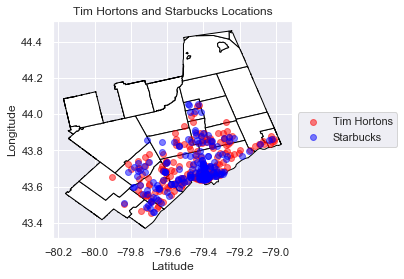

In [71]:
ax = gta.plot(
    color='white', edgecolor='black')

timhortons.plot(ax=ax, color='red', alpha=0.5, label = 'Tim Hortons')
starbucks.plot(ax=ax, color='blue', alpha=0.5, label = 'Starbucks')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Tim Hortons and Starbucks Locations")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
plt.show()

In [72]:
print('Percentage of Starbucks within 1km: ' + str(stats.percentileofscore(timhortons['nearest_starbucks'], 1)) + '%')
print('Percentage of Starbucks within 2km: ' + str(stats.percentileofscore(timhortons['nearest_starbucks'], 2)) + '%')

Percentage of Starbucks within 1km: 59.01639344262295%
Percentage of Starbucks within 2km: 79.09836065573771%


In [74]:
check = timhortons.groupby('city')['nearest_starbucks'].describe().sort_values(by='count')
timmys = check.drop(columns=['25%', '75%'])
timmys = timmys.reset_index()
timmys['population'] = [findpop(x) for x in timmys['city']]
display(timmys)

,city,count,mean,std,min,50%,max,population
0,Halton Hills,1.0,7.925562,NaN,7.925562,7.925562,7.925562,61161
1,King,1.0,5.405239,NaN,5.405239,5.405239,5.405239,24512
2,Milton,1.0,0.173407,NaN,0.173407,0.173407,0.173407,110128
3,Whitchurch-Stouffville,1.0,9.335472,NaN,9.335472,9.335472,9.335472,45837
4,Aurora,2.0,1.874816,0.297910,1.664161,1.874816,2.085470,55445
5,Newmarket,2.0,1.192519,0.220572,1.036551,1.192519,1.348486,84224
6,Pickering,5.0,1.430915,1.083371,0.158614,2.033908,2.535236,91771
7,Ajax,6.0,1.523778,0.868459,0.416458,1.679034,2.798948,119677
8,Oakville,6.0,1.661013,1.333108,0.169667,1.628548,3.301628,193832
9,Brampton,11.0,1.860293,1.348020,0.292594,1.521695,4.830057,593638


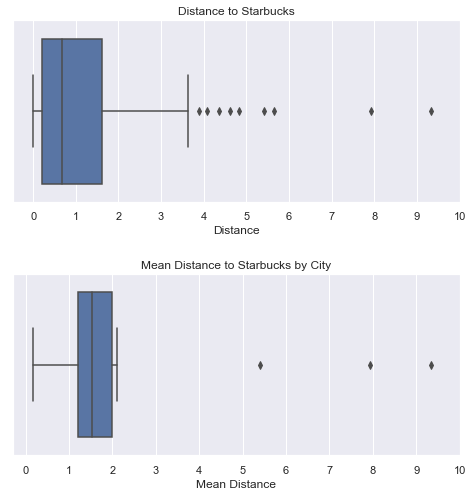

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

sns.boxplot(timhortons['nearest_starbucks'], ax = axs[0])
axs[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
axs[0].set_xlabel("Distance")
axs[0].set_title("Distance to Starbucks")

sns.boxplot(timmys['mean'], ax = axs[1])
axs[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
axs[1].set_xlabel("Mean Distance")
axs[1].set_title("Mean Distance to Starbucks by City")

plt.show()

We can see from the map that while both Tim Hortons and Starbucks are crowded in the more concentrated regions of the GTA, there are a few locations out of downtown Toronto that are spread out further away. 

Looking at the boxplots of distances from a Tim Hortons to its nearest Starbucks, we can see that outliers begin a little below 4 kilometres, and the 75th percentile is below 2km and very left skewed, so the majority of Tim Hortons have a Starbucks nearby.  59% of Tim Hortons locations have a Starbucks within 1 km, and 79% have a Starbucks within 2 km.  

Looking at the chart of distances for each individual city, only five out of the sixteen cities have a median below 1 kilometre.  However, three of these five cities have the highest count of businesses in them. As well, looking at the boxplot of mean distances per city, the majority of cities where we would have to walk more than 2 kilometres to find a Starbucks are all outliers.

So we conclude that there usually is a Starbucks within 2km of a Tim Hortons for all the Tim Hortons in this dataset, mostly for Tim Hortons in cities with many businesses.

## 4.5. Do Yelp reviewers use similar language in their reviews of GTA's Tim Horton's and Starbucks?

We will investigate the users who have made reviews for both Tim Hortons and Starbucks, and see if their is a significant difference in the language they use in their reviews.  We will investigate their language through checking if the most frequently used words in their reviews are relatively the same for both franchises, not including stopwords.  We will also investigate it through the lexical diversity used in Tim Hortons reviews versus Starbucks reviews.

In [76]:
# we want reviews of tim hortons and starbucks by the same users
# for every tim hortons review, we see if the user has also made a starbucks review

timhortonsids = set(timhortons['business_id'])
check = [x in timhortonsids for x in reviewdat['business_id']]
timhortonsreviews = reviewdat[check]
timhortonsreviews = timhortonsreviews.reset_index(drop=True)

starbucksids = set(starbucks['business_id'])
check = [x in starbucksids for x in reviewdat['business_id']]
starbucksreviews = reviewdat[check]
starbucksreviews = starbucksreviews.reset_index(drop=True)

In [77]:
sharedusers = []

for i in range(len(timhortonsreviews)):
    user = timhortonsreviews.loc[i]['user_id']
    if user not in sharedusers:
        if user in list(starbucksreviews['user_id']):
            sharedusers.append(user)

In [78]:
compiledreviews = pd.DataFrame()
compiledreviews['user_id'] = sharedusers

def getreviews(userid, data):
    return list(data[data['user_id'] == userid]['text'])

def listtostring(stringlist):
    compiled = ""
    for i in range(len(stringlist)):
        compiled = compiled + " " + stringlist[i]
    return compiled

compiledreviews['Tim Hortons Reviews'] = [getreviews(x, timhortonsreviews) for x in sharedusers]
compiledreviews['Starbucks Reviews'] = [getreviews(x, starbucksreviews) for x in sharedusers]
compiledreviews['Compiled TH Reviews'] = [listtostring(x) for x in compiledreviews['Tim Hortons Reviews']]
compiledreviews['Compiled SB Reviews'] = [listtostring(x) for x in compiledreviews['Starbucks Reviews']]

In [79]:
import nltk
from nltk.corpus import stopwords

# looking at the 20 most frequently used words in Tim Hortons reviews and Starbucks reviews,
# we count the percentage of words that are unique.
def getfreqwords(string):
    tokens = nltk.word_tokenize(string)
    # words longer than 1 to get rid of punctuation
    words = [word for word in tokens if len(word) > 1]
    words = [word.lower() for word in words]
    # remove stop words
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if "'" not in word]

    text = nltk.Text(words)
    fdist1 = nltk.FreqDist(text)
    freqwords = [x[0] for x in fdist1.most_common(20)]
    return freqwords

def uniquewordpercent(th_reviews, sb_reviews):
    thfreq = getfreqwords(th_reviews)
    sbfreq = getfreqwords(sb_reviews)
    unique = [x for x in thfreq if x not in sbfreq]
    return len(unique)/20

compiledreviews['Unique Words'] = [uniquewordpercent(compiledreviews.loc[i]['Compiled TH Reviews'], 
                                                     compiledreviews.loc[i]['Compiled SB Reviews']) 
                                   for i in range(len(compiledreviews))]

In [80]:
thfreqwords = []
for i in range(len(compiledreviews)):
    thfreqwords.extend(getfreqwords(compiledreviews.loc[i]['Compiled TH Reviews']))

thfreqwords = pd.Series(thfreqwords).value_counts()[0:10]

sbfreqwords = []
for i in range(len(compiledreviews)):
    sbfreqwords.extend(getfreqwords(compiledreviews.loc[i]['Compiled SB Reviews']))

sbfreqwords = pd.Series(sbfreqwords).value_counts()[0:10]

In [81]:
# most frequent words used in reviews
words = pd.DataFrame()
freq = thfreqwords.append(sbfreqwords)
words["Word"] = freq.index
words["Count"] = freq.values

bus = []
for i in range(10):
    bus.append("Tim Hortons")

for i in range(10):
    bus.append("Starbucks")

words["Business"] = bus

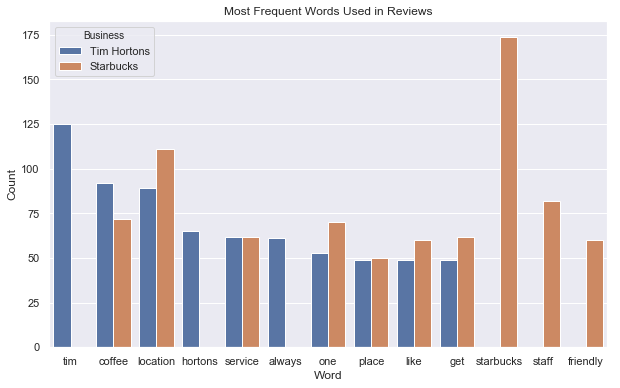

In [82]:
fig, axs = plt.subplots(figsize=(10, 6))
sns.barplot(x="Word", y="Count", hue="Business", data=words, ax = axs)
axs.set_title("Most Frequent Words Used in Reviews")
plt.show()

We look at the words used in Tim Hortons and Starbucks reviews by the same user, and count the most frequent words used for each business, not counting stop words.  We have graphed the top 10 most frequently used words for Tim Hortons and Starbucks. Obviously the names of the business are some of the most frequently used for each respective business.  

We can see that reviews about Tim Hortons tend to use the word 'always' much more than ones about Starbucks, and that reviews about Starbucks tend to use the words 'staff' and 'friendly' much more than ones about Starbucks.  The other words appear at relatively similar counts.  From just the most frequent words used, as well as our previous conclusion from 4.3 that Starbucks in the GTA tend to have more businesses with high reviews that Tim Hortons, we could infer that Starbucks locations tend to have friendlier service than Tim Hortons locations.

In [83]:
# check if there is a difference in lexical diversity in reviews

# count number of unique words divided by number of words
def lexical_diversity(string):
    tokens = nltk.word_tokenize(string)
    words = [word for word in tokens if len(word) > 1]
    words = [word.lower() for word in words]
    return len(set(words)) / len(words)

lexdiv = [lexical_diversity(compiledreviews.loc[i]['Compiled TH Reviews']) - \
          lexical_diversity(compiledreviews.loc[i]['Compiled SB Reviews'])
          for i in range(len(compiledreviews))]
compiledreviews['Lexical Diversity'] = lexdiv

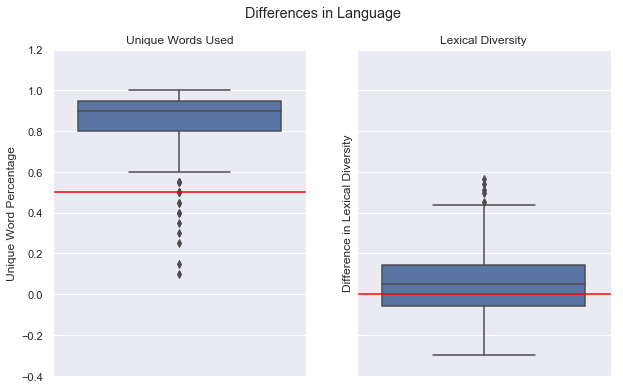

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.boxplot(y = "Unique Words", data = compiledreviews, ax = axs[0])
plt.suptitle("Differences in Language")
axs[0].set_title("Unique Words Used")
axs[0].set_ylabel("Unique Word Percentage")
axs[0].axhline(0.5, color='red')
axs[0].set_ylim(-0.4, 1.2)

sns.boxplot(y = "Lexical Diversity", data = compiledreviews, ax = axs[1])
axs[1].set_title("Lexical Diversity")
axs[1].set_ylabel("Difference in Lexical Diversity")
axs[1].axhline(0, color='red')
plt.show()

We compare for each user, the most frequently used words they use in their Tim Hortons reviews and Starbucks reviews, and note the percentage of those words that are unique to the franchise.  From the comparison of the most frequently used words in Tim Hortons reviews and Starbucks reviews, the percentage of those words that are unique to the franchise are relatively high.  The median is over 0.8, and the lower bound is above 0.5.  All of the users who have a unique word usage per franchise below 0.5 are considered outliers.  This means for most people, the most frequent words used in reviews differ depending on if it's for Tim Hortons or Starbucks.

From the comparison of lexical diversity, we can see that the median is above zero. This means that over fifty percent of users use more kinds of words when reviewing Tim Hortons in comparison to Starbucks.

Therefore we conclude that people do use different language when reviewing Tim Hortons and Starbucks.  People tend to use more kinds of words when reviewing Tim Hortons compared to Starbucks.  From our previous analysis in 4.3, we also know that Tim Hortons gets less reviews and also lower ratings than Starbucks does.  Maybe when people are describing mediocrity in Tim Hortons, they use more colourful language than their Starbucks reviews.

# Conclusion

## Question 2

The Yelp dataset contains businesses clustered in specific regions of North America, rather than an even spread of businesses across the continent.  This makes it extremely unlikely that this is a random independant sample of businesses.  The cities with the most businesses present in this dataset are Las Vegas and Toronto.

The most frequent business categories are Food, Restaurants, Shopping, Home Services, and Beauty & Spa.  Businesses on Yelp that are restaurants tend not to tag their restaurants also as a part of the 'Food' category and go for the more specific tag of what kind of food they serve, so it is likely that Food is the actual most frequent business category.

Establishments with bike parking tend to be of the categories Coffee & Tea, Bars, American (Traditional), Food, Nightlife, Hair Salons, Beauty & Spas, Sandwiches, and Active Life.  Businesses that people can just walk into to use their services tend to have bike parking more than businesses that you can't walk into.

Having more Yelp reviews is somewhat correlated to a higher star rating, but only up to star rating 4.0.  Above 4, review count no longer matters, and businesses with lower review counts have a higher star rating.  This can be see as if a business gets enough high star ratings, everyone automatically assumes that it's a very good establishment and no longer bothers with leaving reviews.

## Question 3

The Canadian cities contained in the Yelp dataset are all from Ontario, Quebec, and Alberta, and mostly concentrated in the Toronto, Montreal, and Calgary metropolitan regions, and a few businesses from neighbouring regions.

## Question 4

In the Greater Toronto Area, notably, Coffee & Tea, Event Planning & Services, and Chinese are much more frequent business categories than overall.  Restaurants, Food, Shopping, Beauty & Spas, Health & Medical, Nightlife, and Bars are of around the same high frequency, and Home Services, Local Services, and Automotives are more prominent overall than in the GTA.

The top franchises are Tim Hortons, Starbucks, and McDonalds by number of businesses.  If we rank the franchises by number of businesses that have a star rating above 3.5, the top franchises are then Starbucks, Tim Hortons, and Second Cup.  While Tim Hortons and McDonalds both have a large number of businesses, they tend to have lower reviews and ratings.  This could be because people care less about lower quality as long as the business is quick and accessable. This ties in with how the majority of franchises with a large number of businesses are fast food/drink places, so they're very accessable for people to spend their money at.

We conclude that business location plays a role in the review count of a business, as well as the popularity of the review. Businesses that are located in higher concentrated places with many businesses, like Downtown Toronto, tend to have higher review counts, and the reviews are more popular.  This can be interpreted as more people living in places with more businesses, and more people leads to more people reviewing and more people liking reviews to increase popularity.
    
It is somewhat true that for every Tim Hortons in the GTA there is a Starbucks nearby. Over 50% of the Tim Hortons in the dataset have a Starbucks within 1km of it.  The locations that don't have a Starbucks with 1km of them all tend to be further from Toronto city, in the areas of the GTA with less businesses, and so less Tim Hortons and Starbucks.

We conclude that Yelp reviewers do use somewhat different language in their reviews of GTA's Tim Horton's and Starbucks. From our analysis we see that over 50% of the more frequently used words in reviews for the two franchises are different.  As well, reviewers tend to use more lexical diversity when reviewing Tim Hortons than Starbucks.

## Limitations
    
Some limitiations of this analysis is that this is the data provided by the Yelp website. Yelp chose business data from specific regions, rather than data spread out across the country. Since this dataset is very concentrated in certain regions, it is not a very good indicator of overall businesses, both in the GTA and overall. The Canadian businesses are only from three different provinces, and not even spread out across the provinces. Especially looking at the map of the businesses in the GTA, it's very concentrated in the south, while there are little to no observations for other cities spreading outwards.  So, for example, while we make the conclusion that that the majority of Tim Hortons have a Starbucks nearby, the majority of the data that we used to make that conclusion is from downtown Toronto, and we have little basis for this conclusion in the more northern parts of the GTA.

As well, there are some typos in city and state names which would have resulted in some data getting left out when conducting our investigations.  Another problem is with special characters in the alphabet for names of cities, especially in Quebec.  When reading from the JSON file, many of the special characters such as 'é' got messed up when loaded.  This resulted in less data from Quebec being used in the analysis for Question 3 than actually present, as well as some businesses getting left out because they don't correspond to the exact spelling of a city in the Greater Toronto Area in Question 4.